<a href="https://colab.research.google.com/github/MDFarhan8789/NEURAL-STYLE-TRANSFER/blob/main/NEURAL_STYLE_TRANSFER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision Pillow matplotlib


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19, VGG19_Weights


In [3]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [4]:
# Define transformations to apply to the images
loader = transforms.Compose([
    transforms.Resize((512, 512)),  # Scale imported image to 512x512
    transforms.ToTensor()])  # Transform it into a torch tensor

unloader = transforms.ToPILImage()  # Reconvert into PIL image

# Helper function to load and preprocess images
def image_loader(image_name):
    image = Image.open(image_name)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


In [5]:
# Upload content and style images
from google.colab import files

uploaded = files.upload()


Saving digiart.jpg to digiart.jpg
Saving cat.jpg to cat.jpg


In [6]:
# Assuming the uploaded files are named 'content_image.jpg' and 'style_image.jpg'
content_path = 'cat.jpg'  # Path to your content image
style_path = 'digiart.jpg'  # Path to your style image

content_img = image_loader(content_path)
style_img = image_loader(style_path)

# Check the size of loaded images
print(f"Content image size: {content_img.size()}")
print(f"Style image size: {style_img.size()}")


Content image size: torch.Size([1, 3, 512, 512])
Style image size: torch.Size([1, 3, 512, 512])


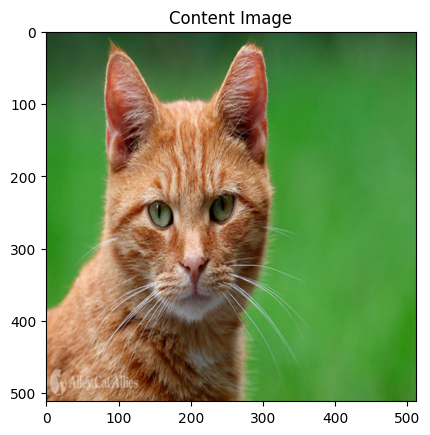

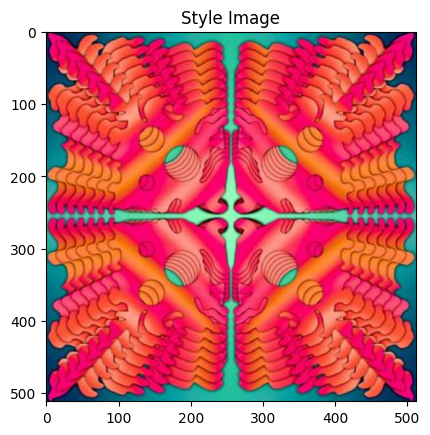

In [7]:
# Function to display an image
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # Clone tensor to not modify original
    image = image.squeeze(0)  # Remove batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Display the content and style images
plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(style_img, title='Style Image')


In [8]:
# Load pre-trained VGG-19 model and its weights
model = vgg19(weights=VGG19_Weights.DEFAULT).features.to(device).eval()

# VGG-19 model requires normalization of the input images
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

# Define content and style loss classes
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()

    def gram_matrix(self, input):
        batch_size, h, w, f_map_num = input.size()
        features = input.view(batch_size * f_map_num, h * w)
        G = torch.mm(features, features.t())
        return G.div(batch_size * f_map_num * h * w)

    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 75.0MB/s]


In [9]:
import copy

# Define the layers to be used for content and style losses
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Function to get the model and the losses
def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  # Incrementing index for conv layers
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # Trimming off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:i + 1]

    return model, content_losses, style_losses

model, content_losses, style_losses = get_style_model_and_losses(model, normalization_mean, normalization_std, style_img, content_img)


In [10]:
# Function to perform style transfer
def run_style_transfer(content_img, style_img, model, num_steps=600,
                       style_weight=1000000, content_weight=1):
    input_img = content_img.clone()

    # Using Adam optimizer instead of LBFGS
    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.01)

    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()

            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"Step {run[0]}:")
                print(f"Style Loss : {style_score.item():4f} Content Loss: {content_score.item():4f}")

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img


In [12]:
# Perform Style Transfer
output_img = run_style_transfer(content_img, style_img, model)
output_img = output_img.squeeze(0).cpu().detach()


Step 50:
Style Loss : 3825.991455 Content Loss: 29.414005
Step 100:
Style Loss : 2000.762207 Content Loss: 31.920803
Step 150:
Style Loss : 1434.153687 Content Loss: 33.188049
Step 200:
Style Loss : 1147.012329 Content Loss: 34.065598
Step 250:
Style Loss : 962.817810 Content Loss: 34.759777
Step 300:
Style Loss : 827.986450 Content Loss: 35.343834
Step 350:
Style Loss : 721.677063 Content Loss: 35.860073
Step 400:
Style Loss : 634.401428 Content Loss: 36.316078
Step 450:
Style Loss : 560.608032 Content Loss: 36.726891
Step 500:
Style Loss : 497.670319 Content Loss: 37.091106
Step 550:
Style Loss : 443.848358 Content Loss: 37.426918
Step 600:
Style Loss : 397.887665 Content Loss: 37.739479


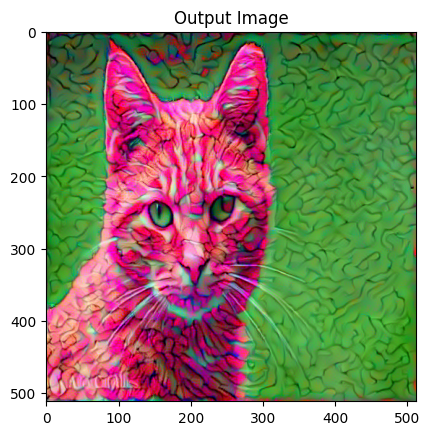

In [13]:
# Convert Tensor to Image and Display
output_image = unloader(output_img)
plt.figure()
plt.imshow(output_image)
plt.title('Output Image')
plt.show()

# Save the output image
output_image.save("output_image.png")